In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber, SarfaComputeResult, get_all_pos, ProgressionVisualizer
from IPython.display import Image, display
from collections import defaultdict

# Overview

This purpose of this notebook is to provide an overview of generating experimental results, a walkthrough of differences between our Sequential SARFA action choice and abalation studies

# Visualization Test

This is an initial test to ensure that our visualization tools are working correctly.

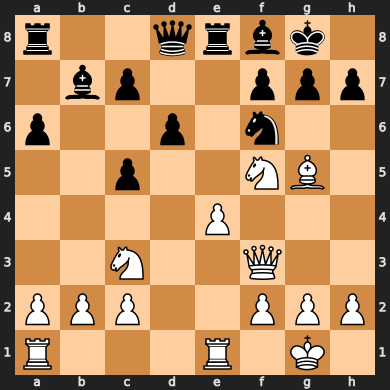

In [3]:
FEN = "r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1"
board = chess.Board(FEN)
board_visualization = BoardVisualization(board)
board_visualization.only_board()

# Algorithm Sanity Test

This is a test to ensure that the algorithm works correctly on the given board infrastructure

In [4]:
# From the dataset - ground truth
TEST_CASE = {"fen":"3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1","responseMoves":["Rxf7"],"saliencyGroundTruth":["f1","h2","c3","e1","b3","h7","g3","g7"],"solution":["Rxf7","Qxc7"]}

In [5]:
# sequential SARFA settings
action = None
DISCOUNT_FACTOR = 0.9
DEPTH = 3
RUNTIME=2.0

## Algorithm Definition

Written out algorithm for sequential SARFA

Parameters
- `fen`: string encoding of the board for chess
- `discount_factor`: for saliency of future timesteps
- `depth`: number of future steps model plays out
- `runtime`: amount of time Stockfish has to compute Q-values

Returns
- `saliency_results`: final mapping of position -> saliency value (float)
- `saliency_results_per_step`: saliency map for each SARFA run
- `moves_taken`: list of moves taken by the Stockfish agent

One important note regarding the implementation is how once an action has been taken, a piece will be a different place than where it was originall.y We make use of `current_to_original_pos_mapping` to keep track of pieces we moved and ensure that final saliency values update the original position and not the current one.

In [12]:
engine = Engine("./stockfish_15_x64_avx2")

def sequential_saliency_algorithm(fen, discount_factor, depth, runtime=2.0):
    saliency_results_per_step = []
    moves_taken = []
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    
    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}

    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        saliency_calculator = SarfaBaseline(engine, board, runtime=runtime)
        
        optimal_move, optimal_move_q = None, 0
        saliency_results_timestep = defaultdict(int)

        for perturbed_board, perturbed_position_str in perturber.process():
            sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)

            # update the optimal action for this depth
            # don't take an action that is coming from perturbation
            # leading to check
            if sarfa_compute_result.optimal_move_q_val != float("inf") and \
                (not optimal_move or sarfa_compute_result.optimal_move_q_val > optimal_move_q):
                optimal_move = sarfa_compute_result.optimal_move
                optimal_move_q = sarfa_compute_result.optimal_move_q_val
            
            # update original board position saliency for the result
            perturbed_position_original_str = current_to_original_pos_mapping[perturbed_position_str]
            saliency_results[perturbed_position_original_str] += (sarfa_compute_result.saliency * (discount_factor ** curr_step))

            # make a copy that is used for visualizing timestamp saliencing
            saliency_results_timestep[perturbed_position_str] += sarfa_compute_result.saliency
        if not optimal_move:
            print("no vaid move found")
            break
        saliency_results_per_step.append((saliency_results_timestep.copy(), board.copy()))

        # take optimal action on the current board
        # use this new board is the action for next iteration
        optimal_move_obj = chess.Move.from_uci(optimal_move)
        moves_taken.append(optimal_move_obj)
        board.push(optimal_move_obj)

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = optimal_move[0:2]
            end_move_pos = optimal_move[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break
    
    return saliency_results, saliency_results_per_step, moves_taken

## 2 Seconds

This is an sanity check to ensure that the Sequential SARFA algorithm runs with set parameters.

In [7]:
saliency_results_2sec, saliency_results_per_step_2sec, moves_taken_2sec = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH, runtime=2.0)

curr step: 0
curr step: 1
curr step: 2


Below is the output of the final results of the Sequential SARFA algorithm.

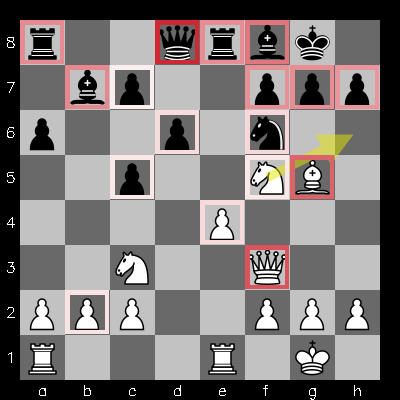

In [9]:
# Final resulting saliency map
board_visualization = BoardVisualization(chess.Board(FEN))
path = board_visualization.show_heatmap(saliency_results_2sec, moves_taken_2sec[0])
display(Image(path))

Below we can see the resulting saliency maps for each of the timesteps. At each timestep, we can see the what pieces were marked salient and what moves Stockfish predicts will be taken

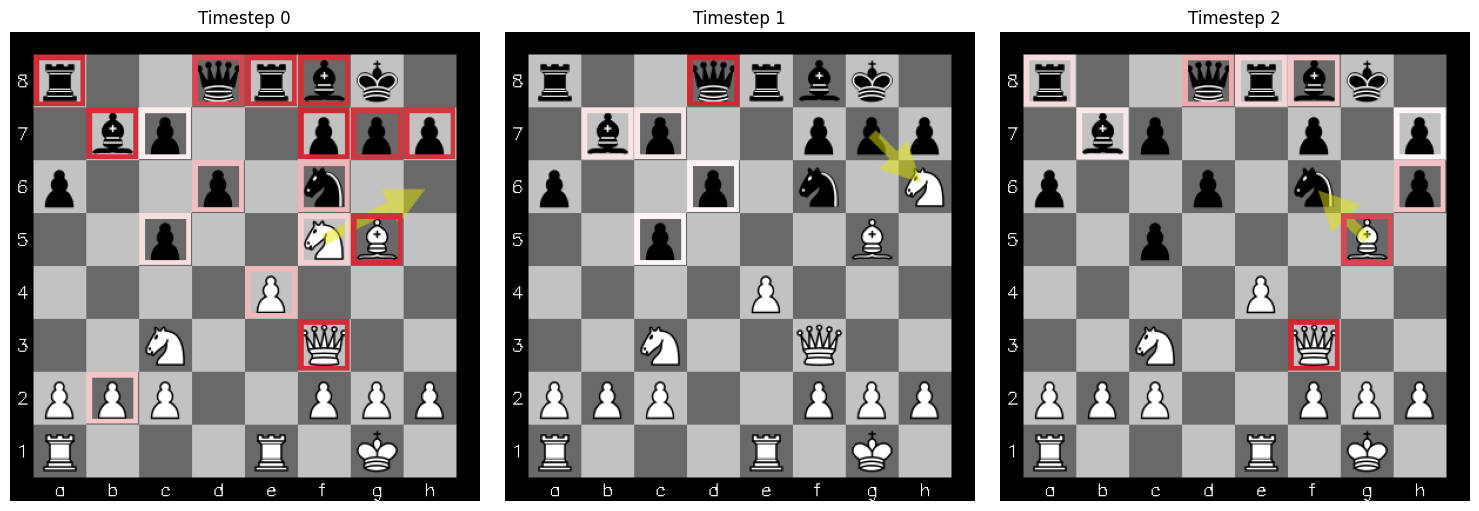

In [17]:
# saliency per timestep
progression_visualizer = ProgressionVisualizer(saliency_results_per_step, moves_taken)
fig = progression_visualizer.show()
fig.show()

# Benchmark

The following code is used to execute experimental results for set hyperparameters.

In [10]:
from chess_dataset import SarfaBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [17]:
# function used by benchmark to produce saliency map given FEN
# matches expected function signature of the benchmark function
sequential_benchmark_function = lambda x, _: sequential_saliency_algorithm(x, DISCOUNT_FACTOR, DEPTH, RUNTIME)[0]

## Hyperparameters

Settings for the benchmark that is going to be run. You can list your hyperparameters below and then run the benchmark.

In [16]:
# settings
DISCOUNT_FACTOR = 0.9
DEPTH = 3
RUNTIME=2.0

name = f"sarfa_sequential_{int(RUNTIME * 10)}_{int(DISCOUNT_FACTOR * 100)}_{DEPTH}"
name

'sarfa_sequential_20_90_3'

## Run

This will execture the experimental results collection. The output will be saved to the `output/` folder

`sanity_check=True` to run only 5 and see if your code is working. 

The results will be saved in `output/{file_name}` where `file_name` is the name the above cell above.

Note: Results of Sanity Check will be `{file_name}.sanity.pkl` to avoid accidental overrides.

In [18]:
benchmark = SarfaBenchmark.run(sequential_benchmark_function, name=name, sanity_check=True)

2r2rk1/pp1bqpp1/2nppn1p/2p3N1/1bP5/1PN3P1/PBQPPPBP/3R1RK1 w - - 0 1
curr step: 0
curr step: 1
curr step: 2
r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1
curr step: 0
curr step: 1
curr step: 2
2r4k/3r1p1p/1p2pP2/p2pPp1P/P2P1Q2/6R1/4B1PK/2q5 w - - 0 1
curr step: 0
curr step: 1
curr step: 2
R4rk1/5bb1/1N1Qpq1p/3pn1p1/3N4/2P2P1P/P5P1/5B1K w - - 0 1
curr step: 0
curr step: 1
curr step: 2
5r1k/bp4pp/1n6/5qN1/1PR5/P2Q3P/5PP1/6K1 w - - 0 1
curr step: 0
curr step: 1
curr step: 2


# Analysis

The following are section of notebooks for analysing results.

## Invididual Benchmark Analysis

Use the cell below to change what benchmark you are loading

In [20]:
name = "sarfa_sequential_20_90_3"
sarfa_benchmark = SarfaBenchmark.load_results(sequential_benchmark_function, name)

In [21]:
sarfa_benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7143901852504448}

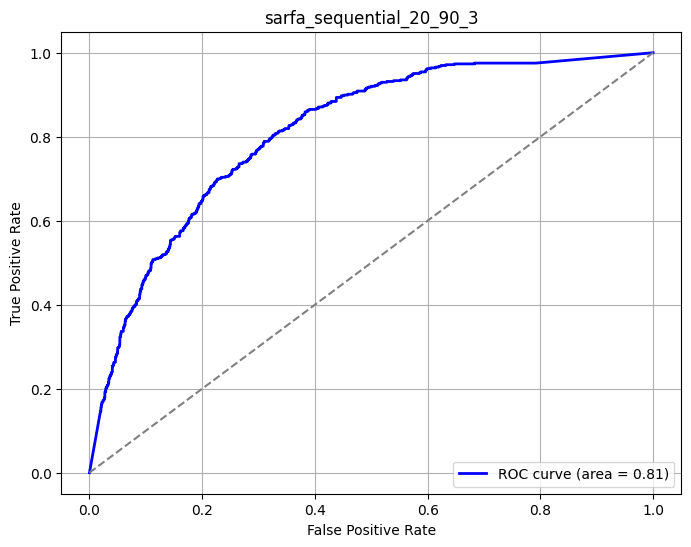

In [22]:
fig = sarfa_benchmark.plot_roc(name=name)
display(fig)

## Show Divergent Move Choices

Goal of this is to show that the Stockfish 15 is choosing different actions than what the expert in the dataset are saying to choose

We will be using this test case to demonstate:

In [23]:
TEST_CASE_DIVERGENT = {
    "fen":"3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1",
    "responseMoves":["Rxf7"],
    "saliencyGroundTruth":["f1","h2","c3","e1","b3","h7","g3","g7"],
    "solution":["Rxf7","Qxc7"]
}

### Stockfish Optimal

Below, we will examine what moves the Stockfish agent chooses as optimal and the resulting salency maps.

In [24]:
FEN = TEST_CASE_DIVERGENT["fen"]
board = chess.Board()
board_visualizer = BoardVisualization(board.copy())

predicted_saliency_optimal, predicted_saliency_timestamps_optimal, predicted_moves_optimal = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH)


curr step: 0
curr step: 1
curr step: 2


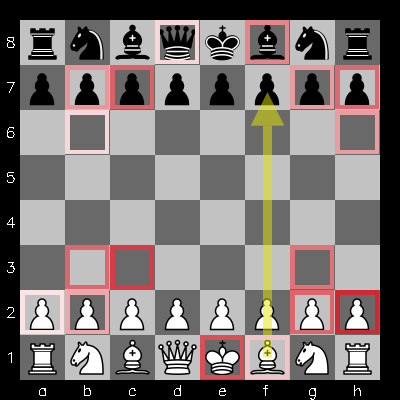

In [25]:
board_visualizer = BoardVisualization(board.copy())

path = board_visualizer.show_heatmap(predicted_saliency_optimal, predicted_moves_optimal[0])
display(Image(path))

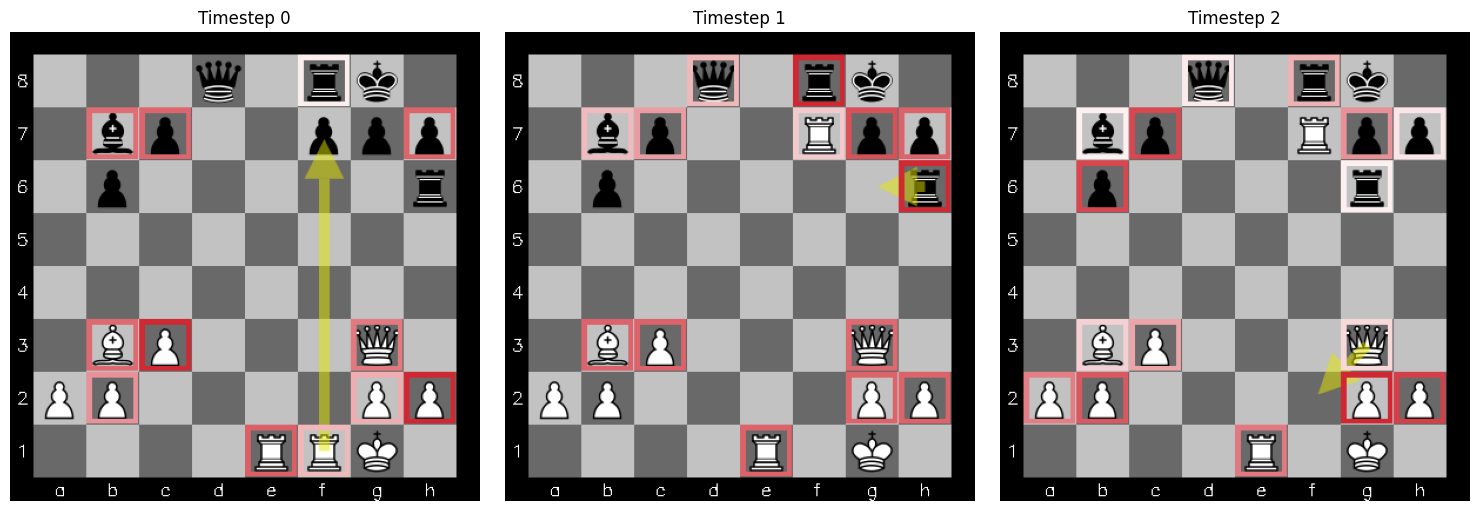

In [26]:
# saliency per timestep
progression_visualizer = ProgressionVisualizer(predicted_saliency_timestamps_optimal, predicted_moves_optimal)
fig = progression_visualizer.show()
fig.show()

### Dataset Expert Moves and Saliency

Below, you will see data parsing to wrangle the moves the expert recommends and to create the saliency map. Note the labels aren't saliency value percentages, experts label a piece as salient or not absolutely.

In [34]:
# ground truth moves should be the agent action and opponent actions alternating
ground_truth_moves = []

i, j = 0, 0
while i < len(TEST_CASE_DIVERGENT["solution"]) and j < len(TEST_CASE_DIVERGENT["responseMoves"]):
    ground_truth_moves.append(TEST_CASE_DIVERGENT["solution"][i])
    ground_truth_moves.append(TEST_CASE_DIVERGENT["responseMoves"][j])
    i += 1
    j += 1

for i_ in range(i, len(TEST_CASE_DIVERGENT["solution"])):
    ground_truth_moves.append(TEST_CASE_DIVERGENT["solution"][i_])

for j_ in range(j, len(TEST_CASE_DIVERGENT["responseMoves"])):
    ground_truth_moves.append(TEST_CASE_DIVERGENT["responseMoves"][j_])

ground_truth_moves

['Rxf7', 'Rxf7', 'Qxc7']

In [64]:
# create saliency ground truth from dataset sample
ground_truth_saliency = {k: 1 for k in TEST_CASE_DIVERGENT["saliencyGroundTruth"]}
ground_truth_saliency

{'f1': 1, 'h2': 1, 'c3': 1, 'e1': 1, 'b3': 1, 'h7': 1, 'g3': 1, 'g7': 1}

In [65]:
board = chess.Board(FEN)
saliency_timeline_ground_truth = []
moves_expert = []
for move in ground_truth_moves:
    saliency_timeline_ground_truth.append((
        saliency,
        board.copy())
    )
    uci = board.push_san(move)
    moves_expert.append(uci)

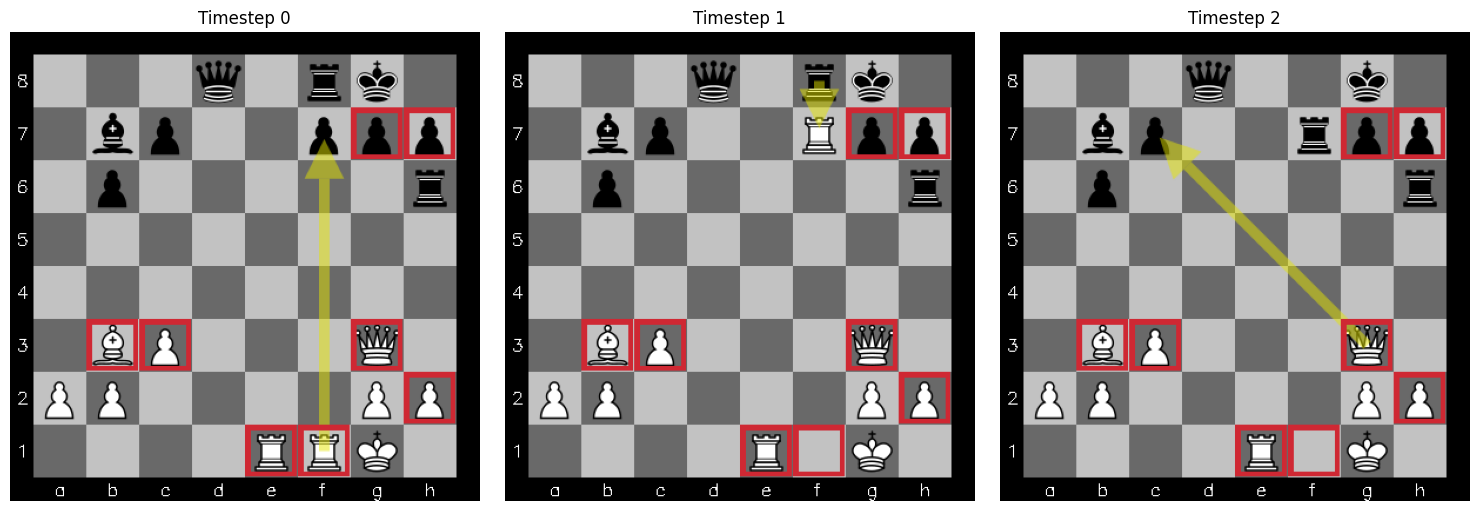

In [66]:
progression_visualizer = ProgressionVisualizer(saliency_timeline_ground_truth, moves_expert)
fig = progression_visualizer.show()
fig.show()

### Stockfish with Forced Actions

As of now, we have compared stockfish value function and stockfish taking optimal moves to the expert moves and expert saliency labels. We should also consider how Stockfish value function computes saliency when the agent takes the expert's actions.

Because of this, we re-write `sequential_saliency_algorithm_forced` which is a modified version of the original Sequential SARFA algorithm which follows predefined actions not the calculated optimal action.

In [46]:
engine = Engine("./stockfish_15_x64_avx2")

def sequential_saliency_algorithm_forced(fen, discount_factor, depth, forced_moves, runtime=2.0):
    saliency_results_per_step = []
    moves_taken = []
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    
    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}

    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        saliency_calculator = SarfaBaseline(engine, board, runtime=runtime)
        
        optimal_move, optimal_move_q = None, 0
        saliency_results_timestep = defaultdict(int)

        for perturbed_board, perturbed_position_str in perturber.process():
            sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)

            # update the optimal action for this depth
            # don't take an action that is coming from perturbation
            # leading to check
            if sarfa_compute_result.optimal_move_q_val != float("inf") and \
                (not optimal_move or sarfa_compute_result.optimal_move_q_val > optimal_move_q):
                optimal_move = sarfa_compute_result.optimal_move
            
            perturbed_position_original_str = current_to_original_pos_mapping[perturbed_position_str]
            saliency_results[perturbed_position_original_str] += (sarfa_compute_result.saliency * (discount_factor ** curr_step))
            saliency_results_timestep[perturbed_position_original_str] += sarfa_compute_result.saliency
        if not optimal_move:
            print("no vaid move found")
            break
        saliency_results_per_step.append((saliency_results_timestep.copy(), board.copy()))

        # NOTE: forced to take the provided moves rather than 
        # the optimal move calculated
        move_uci = board.push_san(forced_moves[curr_step])
        moves_taken.append(move_uci)

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = optimal_move[0:2]
            end_move_pos = optimal_move[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break
    
    return saliency_results, saliency_results_per_step, moves_taken

In [51]:
predicted_saliency_forced, predicted_saliency_timestamps_forced, predicted_moves_forced = sequential_saliency_algorithm_forced(FEN, DISCOUNT_FACTOR, DEPTH, ground_truth_moves)


curr step: 0
curr step: 1
curr step: 2


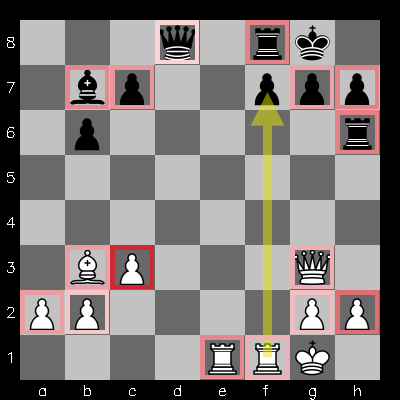

In [52]:
# resulting saliency map
board = chess.Board(FEN)
board_visualizer = BoardVisualization(board.copy())
path = board_visualizer.show_heatmap(predicted_saliency_forced, predicted_moves_forced[0])
display(Image(path))

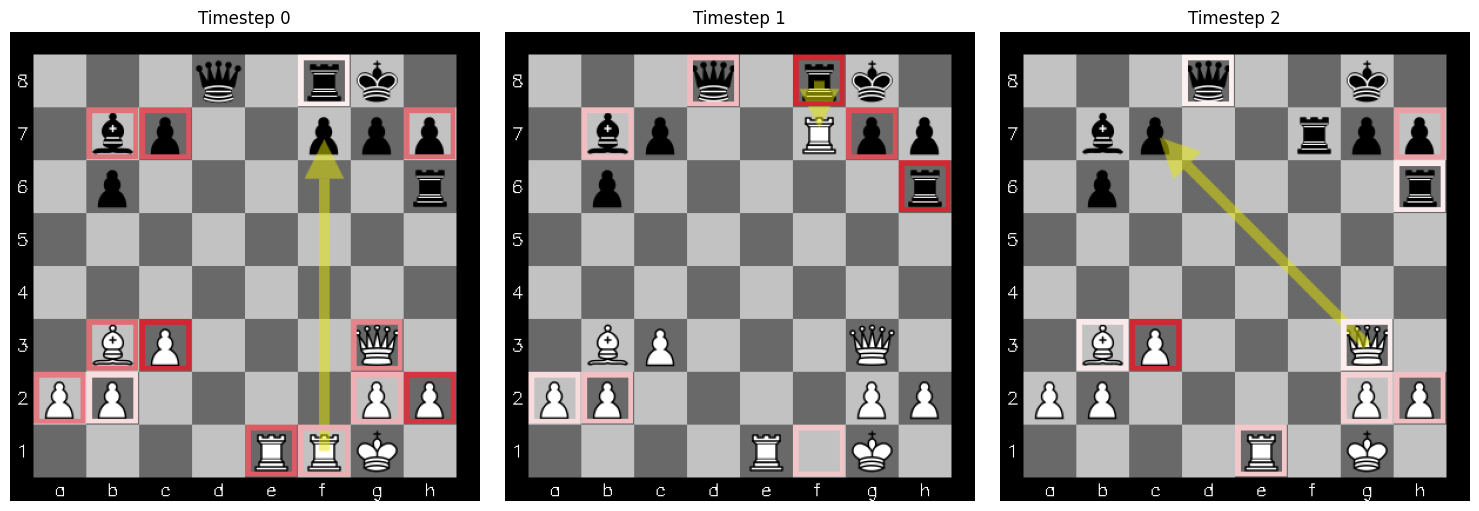

In [54]:
# saliency amps per timestamp
progression_visualizer = ProgressionVisualizer(predicted_saliency_timestamps_forced, predicted_moves_forced)
fig = progression_visualizer.show()
fig.show()

### Final Board Comparisons

Generate image from report of al lthe permutations of different action choices and how the saliency maps are different

In [67]:
# Show the final board for ground truth and calculated side by side
from PIL import Image as PILImage

import matplotlib.pyplot as plt
from PIL import Image as PILImage

def show_saliency_comparison(fen, saliencies, names, best_move: chess.Move):
    """
    Displays a comparison of saliency heatmaps in a 1 x n row.
    Takes in a list of saliencies and corresponding names.
    
    Parameters:
    - fen (str): FEN of the current chessboard.
    - saliencies (list): List of saliency data for each heatmap.
    - names (list): List of titles to be used for each subplot.
    - best_move (chess.Move): The best move to be visualized on the board.
    """
    
    # Initialize the board visualizer
    board_visualizer = BoardVisualization(chess.Board(fen))

    # Create a figure with 1 row and n columns (length of the saliencies list)
    fig, axes = plt.subplots(1, len(saliencies), figsize=(12, 6))

    # Ensure axes is iterable even if there's only one subplot
    if len(saliencies) == 1:
        axes = [axes]

    # Loop over each saliency and its corresponding name
    for i, (saliency, name) in enumerate(zip(saliencies, names)):
        board_visualizer.DRAWING_FILE = f"svg_custom/board_{name}"
        path = board_visualizer.show_heatmap(saliency, best_move)
        
        # Load the saliency image
        img = PILImage.open(path)
        
        # Display the image in the corresponding subplot
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide the axes
        axes[i].set_title(name)

    # Adjust the layout to avoid overlap
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)  # Reduce the width spacing


    # Show the plot
    plt.show()

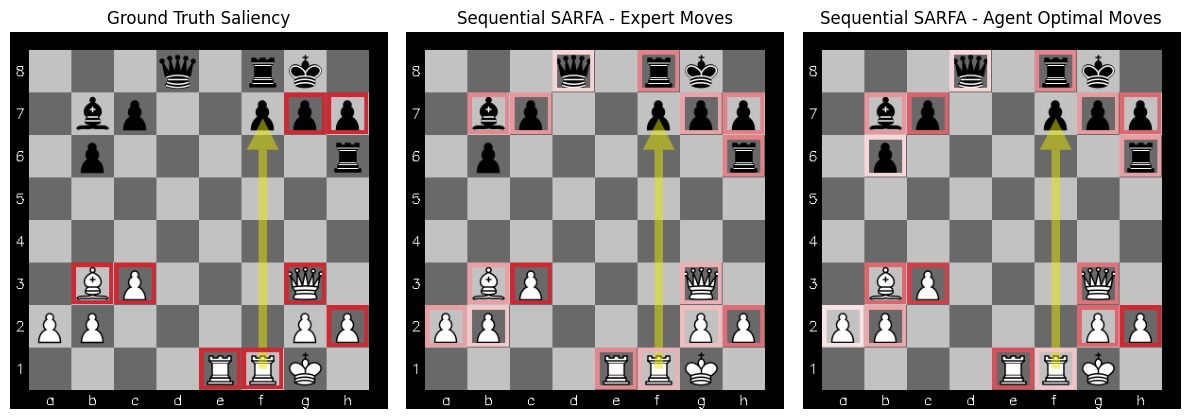

In [69]:
board = chess.Board(FEN)
possible_moves = list(board.legal_moves)
_, optimal_move = engine.q_values(board, possible_moves, len(possible_moves), runtime=2.0)

show_saliency_comparison(FEN, 
    [ground_truth_saliency, predicted_saliency_forced, predicted_saliency_optimal], 
    ["Ground Truth Saliency", "Sequential SARFA - Expert Moves", "Sequential SARFA - Agent Optimal Moves"],
    chess.Move.from_uci(optimal_move))

From the above visualization, it is clear that Sequential SARFA itself produces a significantly different saliency map even when using the same Q-value function. This proves that the Sequential SARFA algorithm itself is novel and any difference in performance is from the algorithm and not just the difference in engine.

## Qualitative Analysis

In the following section, you will see a situation which is an endgame where running Sequential SARFA clearly demonstrates the strategy the agent is trying to take. SARFA is not able to highlight saliency of pieces that the agent is considering currently for future moves.

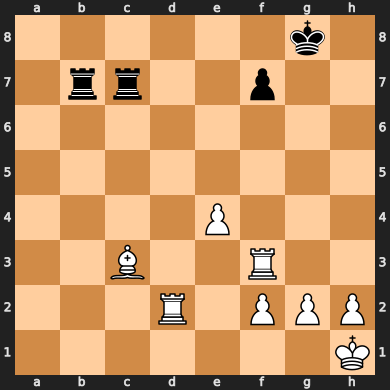

In [71]:
FEN = "6k1/1rr2p2/8/8/4P3/2B2R2/3R1PPP/7K w - - 0 1"
board = chess.Board(FEN)
board_visualizer = BoardVisualization(board.copy())
board_visualizer.only_board()

In [72]:
# to allow for tesing of regular SARFA
def saliency_algorithm(fen, action=None) -> dict[str, float]:
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    saliency_calculator = SarfaBaseline(engine, board, runtime=RUNTIME)
    for perturbed_board, perturbed_position_str in perturber.process():
        saliency_result = saliency_calculator.compute(perturbed_board, 
        action)
        saliency_results[perturbed_position_str] = saliency_result.saliency

    return saliency_results


### Sequential SARFA
In this situation, we will be considering a depth of 5 for Sequential SARFA. This will have it consider all the way to the end game of this board when black is in checkmate.

In [79]:
DEPTH=5

sequential_sarfa_saliency, sequential_sarfa_saliency_timestamps, sequential_sarfa_predicted_moves = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH)


curr step: 0
curr step: 1
curr step: 2
curr step: 3
curr step: 4
game finished early


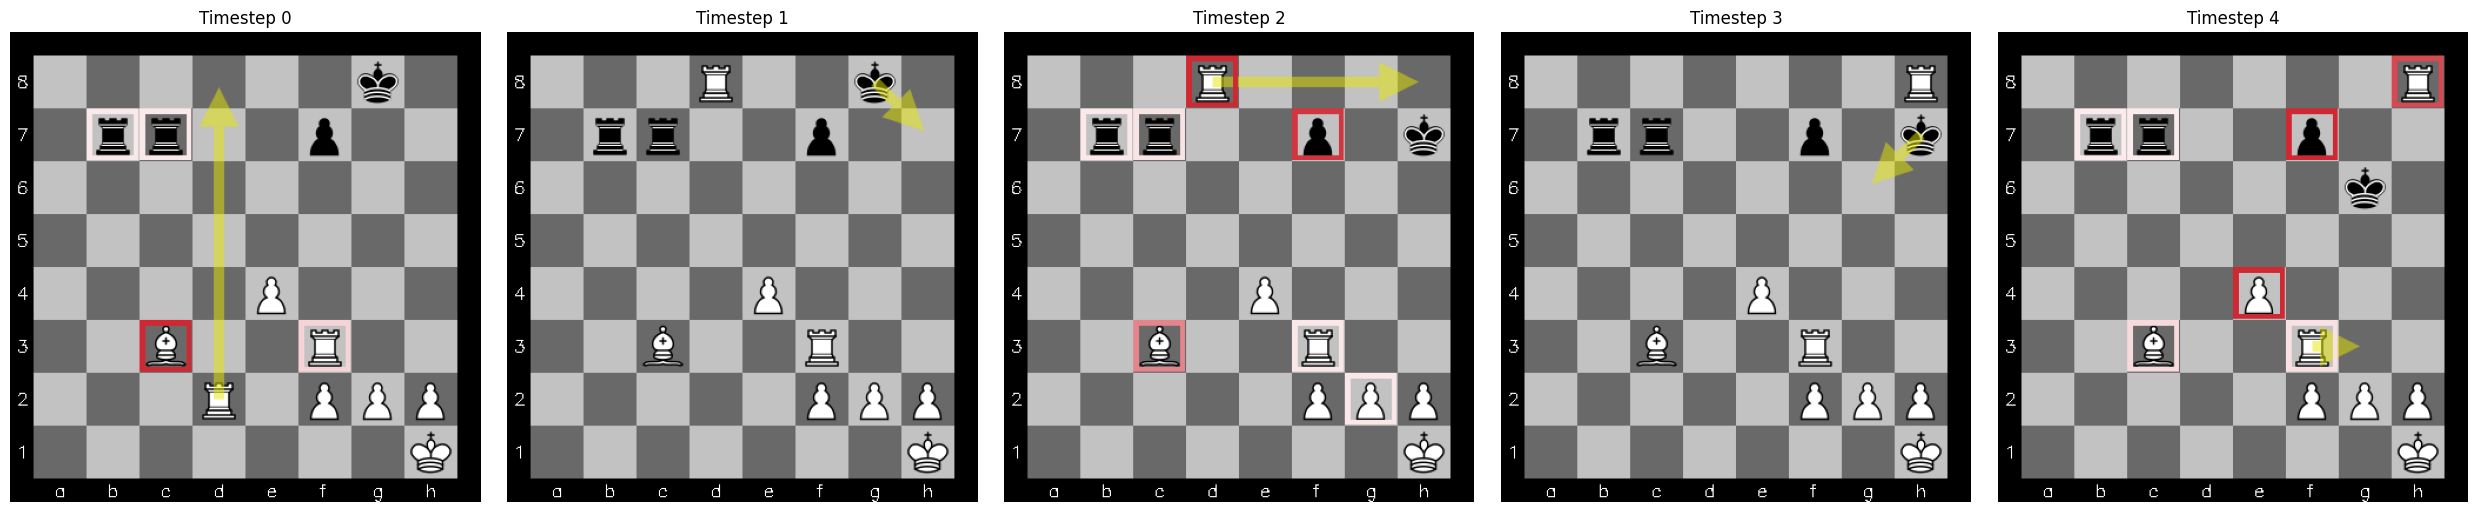

In [80]:
# timeline of saliency maps and moves
progression_visualizer = ProgressionVisualizer(sequential_sarfa_saliency_timestamps, sequential_sarfa_predicted_moves)
fig = progression_visualizer.show()
fig.show()

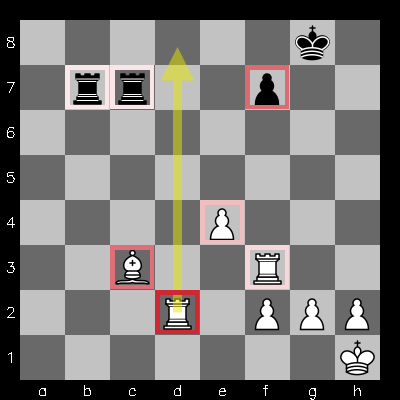

In [77]:
path = board_visualizer.show_heatmap(sequential_sarfa_saliency, sequential_sarfa_predicted_moves[0])
display(Image(path))

### SARFA

This will be used to compare how regular sarfa compared to the Sequential SARFA algorithm.

In [76]:
sarfa_saliency = saliency_algorithm(FEN)

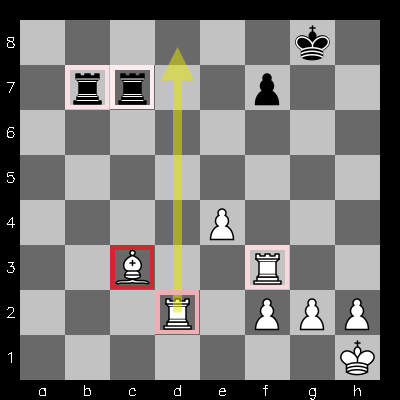

In [78]:
path = board_visualizer.show_heatmap(sarfa_saliency, predicted_moves[0])
display(Image(path))

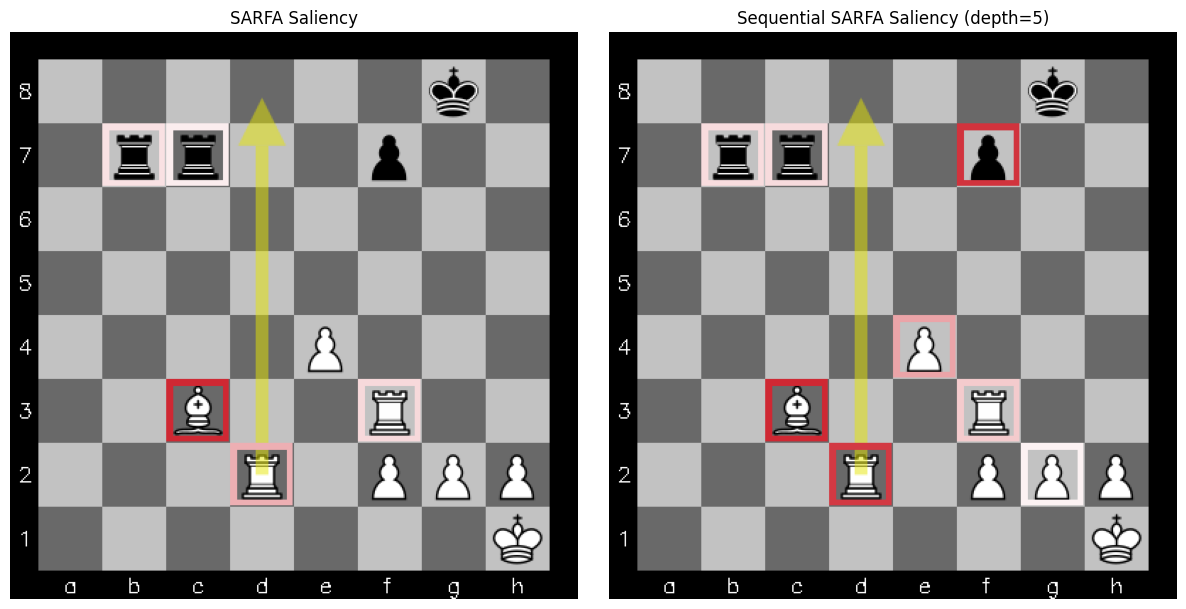

In [81]:
show_saliency_comparison(FEN, [sarfa_saliency, sequential_sarfa_saliency], ["SARFA Saliency", "Sequential SARFA Saliency (depth=5)"], sequential_sarfa_predicted_moves[0])

From the above diagram, its important to see the difference in saliencies. E4 and F7 are highlighted in Sequential SARFA but not in regular SARFA. This is key because it shows how its exploting E4's positioning on E5 to push the Black King up and get stuck. This is not clear in the SARFA implementation and shows the value of Sequential SARFA.

# Ablation Study

The following studies require certain data to exist on your file system that is calculated experimentally. Ensure you ahve the required data downloaded before running any of the cells.

You can still view the results of our analysis below, but be careful not to run the cells!

In [82]:
from chess_dataset import SarfaBenchmark

## Setup ROC Curve visualization

This is some code setup to ensure that you can compare multiple ROC curves on the same matplotlib graph.

In [91]:
import matplotlib.pyplot as plt

def compare_roc(roc_data):

    # Plotting
    plt.figure(figsize=(8, 6))
    for roc in roc_data:
        roc_auc = auc(roc["fpr"], roc["tpr"])
        plt.plot(roc["fpr"], roc["tpr"], label=f"{roc['label']} (AUC = {roc_auc:.2f})")

    # Adding diagonal line for reference
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

    # Customization
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curves for Depth')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


## Depth
See how the depth of running Sequential SARFA impacts performance. __This will require you to run the benchmark for__
1. SARFA Sequential with runtime = 0.2, discount factor of 0.9, and depth of 1
2. SARFA Sequential with runtime = 0.2, discount factor of 0.9, and depth of 2
3. SARFA Sequential with runtime = 0.2, discount factor of 0.9, and depth of 3

In [88]:
# loading benchmarks from `output/`
benchmark_1 = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_20_90_1")
benchmark_2 = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_20_90_2")
benchmark_3 = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_20_90_3")


We can see an overview of the accuracies below. We notice that the depth of 1 had the best performance which is probably because of how the dataset is optimized for finding the next action rather than the next action in the context of the strategy.

It is important to note that the Q-value calculation can have high variance due to timing which can also lead the the results we see.

In [87]:
print(f"Depth of 1 accuracy: {benchmark_1.accuracy() * 100 : .2f}%")
print(f"Depth of 2 accuracy: {benchmark_2.accuracy() * 100 : .2f}%")
print(f"Depth of 3 accuracy: {benchmark_3.accuracy() * 100 : .2f}%")


Depth of 1 accuracy:  74.99%
Depth of 2 accuracy:  70.74%
Depth of 3 accuracy:  71.44%


From the ROC curves we can clearly see differences in performance which imply that the depth does have an impact on the output of the Sequential SARFA algorithm.

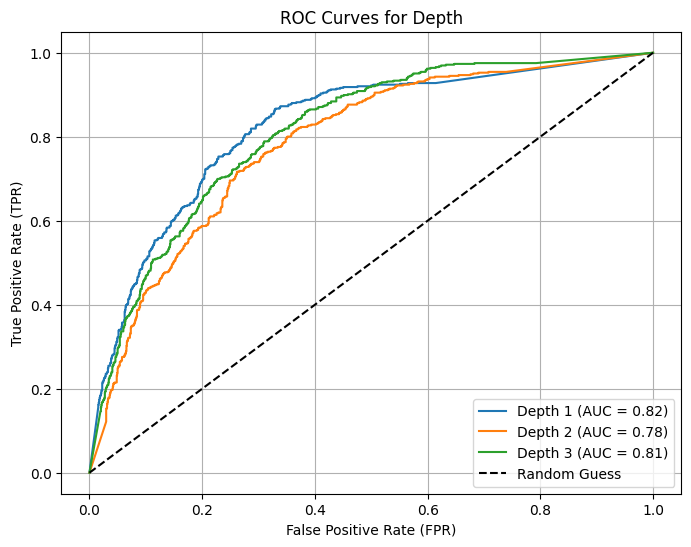

In [97]:
# roc curve for different depths
fpr_1, tpr_1 = benchmark_1.roc_curve()
fpr_2, tpr_2 = benchmark_2.roc_curve()
fpr_3, tpr_3 = benchmark_3.roc_curve()


roc_data_depth = [
    {"fpr": fpr_1, "tpr": tpr_1, "label": "Depth 1"},
    {"fpr": fpr_2, "tpr": tpr_2, "label": "Depth 2"},
    {"fpr": fpr_3, "tpr": tpr_3, "label": "Depth 3"}
]

compare_roc(roc_data)

## Runtime

View the impact of longer time to calculate Q value and whether it changes Sequential SARFA Performance. Note that the more time that you provide Stockfish to calculate the Q-value the more correct it theoretically is. __This will require you to run the benchmark for__
1. SARFA Sequential with runtime = 0.1, discount factor of 0.9, and depth of 3
2. SARFA Sequential with runtime = 0.2, discount factor of 0.9, and depth of 3
3. SARFA Sequential with runtime = 0.3, discount factor of 0.9, and depth of 3

In [95]:
benchmark_1_sec = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_10_90_3")
benchmark_2_sec = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_20_90_3")
benchmark_3_sec = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_30_90_3")

In [98]:
print(f"1 second accuracy: {benchmark_1_sec.accuracy() * 100 : .2f}%")
print(f"2 second accuracy: {benchmark_2_sec.accuracy() * 100 : .2f}%")
print(f"3 second accuracy: {benchmark_3_sec.accuracy() * 100 : .2f}%")


1 second accuracy:  70.84%
2 second accuracy:  71.44%
3 second accuracy:  71.44%


As we can see above, there is very little difference in accuracy due to chagnes in the runtime of Stockfish when calculating Q-values.

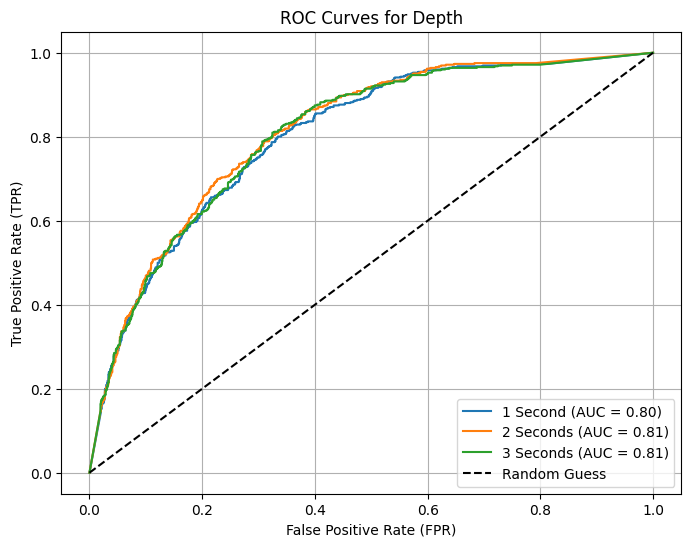

In [96]:
# roc curve for different depths
fpr_1, tpr_1 = benchmark_1_sec.roc_curve()
fpr_2, tpr_2 = benchmark_2_sec.roc_curve()
fpr_3, tpr_3 = benchmark_3_sec.roc_curve()

roc_data_runtime = [
    {"fpr": fpr_1, "tpr": tpr_1, "label": "1 Second"},
    {"fpr": fpr_2, "tpr": tpr_2, "label": "2 Seconds"},
    {"fpr": fpr_3, "tpr": tpr_3, "label": "3 Seconds"}
]

compare_roc(roc_data_runtime)

As we can see above, the change in the runtime for the Q-value has very little impact on performance. This implies that Sequential SARFA is able to find saliency in long-range information that is well captured by Q-values.

# Summary

From this notebook, we can see the code for Sequential SARFA, generate experimental results for a variety of hyperparameters, and analysis of results.

The analysis includes comparing different actions experts in the dataset take compared to Stockfish optimal actions, qualitative analysis of situations Sequential SARFA captures explains better than SARFA, and ablation studies for depth and runtime.